In [1]:
!pip install networkx matplotlib pandas numpy scikit-learn tqdm

# Imports
import os
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

In [3]:
import urllib.request
import tarfile

url = "https://snap.stanford.edu/data/facebook.tar.gz"
output_file = "facebook.tar.gz"


print("Downloading dataset...")
urllib.request.urlretrieve(url, output_file)
print("Download complete!")


print("Extracting dataset...")
with tarfile.open(output_file, "r:gz") as tar:
    tar.extractall()
print("Extraction complete!")


import os
print("Sample files in 'facebook' folder:", os.listdir("facebook")[:10])


Download complete!
Extracting dataset...
Extraction complete!
Sample files in 'facebook' folder: ['0.circles', '0.edges', '0.egofeat', '0.feat', '0.featnames', '107.circles', '107.edges', '107.egofeat', '107.feat', '107.featnames']


C:\Users\Sara Ayman\AppData\Local\Temp\ipykernel_11976\1695711163.py:15: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


Graph created with 333 nodes and 2519 edges


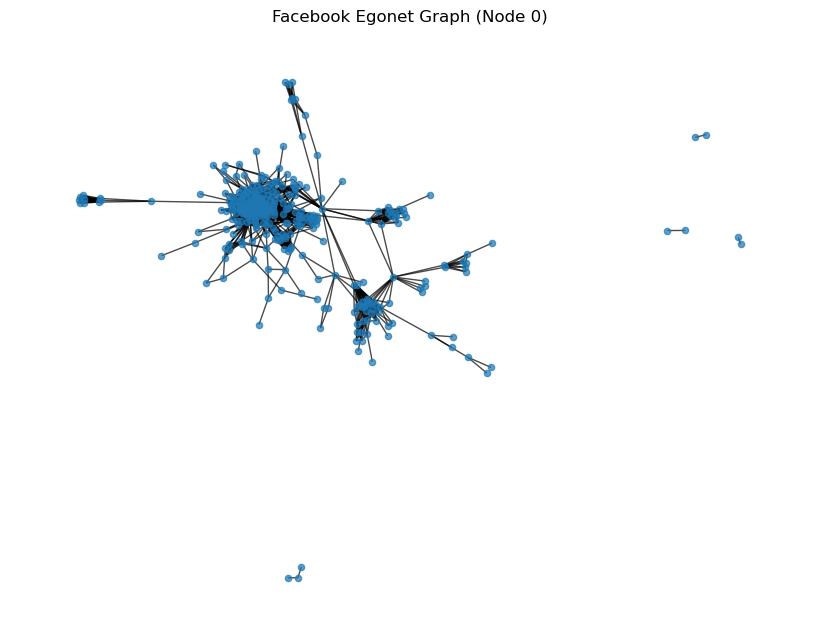

In [5]:

edge_file = "facebook/0.edges"

G = nx.Graph()

with open(edge_file, "r") as f:
    for line in f:
        u, v = line.strip().split()
        G.add_edge(int(u), int(v))

print(f"Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

plt.figure(figsize=(8,6))
nx.draw(G, node_size=20, alpha=0.7)
plt.title("Facebook Egonet Graph (Node 0)")
plt.show()


In [7]:
# ---------------------------
# Graph Metrics Calculation
# ---------------------------

# Degree
degree_dict = dict(G.degree())
print("Sample degrees:", list(degree_dict.items())[:10])

# Clustering Coefficient
clustering_dict = nx.clustering(G)
print("Sample clustering coefficients:", list(clustering_dict.items())[:10])

# Betweenness Centrality
betweenness_dict = nx.betweenness_centrality(G)
print("Sample betweenness centrality:", list(betweenness_dict.items())[:10])

# Community Detection (using greedy modularity)
from networkx.algorithms.community import greedy_modularity_communities
communities = list(greedy_modularity_communities(G))
print(f"Number of communities detected: {len(communities)}")
print("Sizes of first 5 communities:", [len(c) for c in communities[:5]])


Sample degrees: [(236, 36), (186, 43), (122, 62), (285, 46), (24, 15), (346, 26), (271, 72), (304, 54), (176, 13), (9, 56)]
Sample clustering coefficients: [(236, 0.3761904761904762), (186, 0.4739756367663344), (122, 0.3654151242728715), (285, 0.4077294685990338), (24, 0.8857142857142857), (346, 0.49230769230769234), (271, 0.36971830985915494), (304, 0.3640810621942697), (176, 0.6794871794871795), (9, 0.37532467532467534)]
Sample betweenness centrality: [(236, 0.0036426783968166146), (186, 0.005513484981013059), (122, 0.02275394479873336), (285, 0.013690039518144724), (24, 0.00010742876619678861), (346, 0.004653214624572582), (271, 0.014974371862728144), (304, 0.013548427225663939), (176, 0.00016267493292471734), (9, 0.009852641667689977)]
Number of communities detected: 12
Sizes of first 5 communities: [119, 52, 47, 38, 27]


In [9]:
# ---------------------------
# Feature Extraction for Bot Detection
# ---------------------------

# Create a DataFrame for nodes
nodes = list(G.nodes())
features = pd.DataFrame({
    "node": nodes,
    "degree": [degree_dict[n] for n in nodes],
    "clustering": [clustering_dict[n] for n in nodes],
    "betweenness": [betweenness_dict[n] for n in nodes],
})

# For communities, assign community ID to each node
community_map = {}
for i, comm in enumerate(communities):
    for node in comm:
        community_map[node] = i

features["community"] = [community_map[n] for n in nodes]

# Display first 10 rows
features.head(10)


,node,degree,clustering,betweenness,community
0,236,36,0.376190,0.003643,0
1,186,43,0.473976,0.005513,0
2,122,62,0.365415,0.022754,0
3,285,46,0.407729,0.013690,0
4,24,15,0.885714,0.000107,2
5,346,26,0.492308,0.004653,2
6,271,72,0.369718,0.014974,0
7,304,54,0.364081,0.013548,0
8,176,13,0.679487,0.000163,0
9,9,56,0.375325,0.009853,0


In [11]:
from sklearn.model_selection import train_test_split

# ---------------------------
# Simulate bot labels
# ---------------------------
np.random.seed(42)


num_bots = int(0.1 * len(features))
bot_nodes = np.random.choice(features["node"], size=num_bots, replace=False)


features["label"] = features["node"].apply(lambda x: 1 if x in bot_nodes else 0)

# ---------------------------
# Prepare data for training
# ---------------------------
X = features[["degree", "clustering", "betweenness", "community"]]
y = features["label"]

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# ---------------------------
# Train Random Forest
# ---------------------------
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Evaluation
print("Baseline Bot Detection Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Baseline Bot Detection Performance:
Accuracy: 0.67

Classification Report:
               precision    recall  f1-score   support

           0       0.67      1.00      0.80        67
           1       0.00      0.00      0.00        33

    accuracy                           0.67       100
   macro avg       0.34      0.50      0.40       100
weighted avg       0.45      0.67      0.54       100



C:\Users\Sara Ayman\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Sara Ayman\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Sara Ayman\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [13]:
# ------------------------------------------
# Structural Evasion Attack
# ------------------------------------------

G_evasion = G.copy()

normal_nodes = set(G.nodes()) - set(bot_nodes)

for bot in bot_nodes:
    # 1) Add 3 random connections to normal nodes
    new_edges = np.random.choice(list(normal_nodes), size=3, replace=False)
    for n in new_edges:
        G_evasion.add_edge(bot, int(n))

    # 2) Remove 1 edge if possible
    if len(list(G_evasion.neighbors(bot))) > 0:
        neighbor_to_remove = list(G_evasion.neighbors(bot))[0]
        G_evasion.remove_edge(bot, neighbor_to_remove)

print("Structural Evasion Attack Completed.")
print(f"Nodes: {G_evasion.number_of_nodes()}, Edges: {G_evasion.number_of_edges()}")


Structural Evasion Attack Completed.
Nodes: 333, Edges: 2582


In [15]:
# ------------------------------------------
# Recalculate Metrics After Evasion Attack
# ------------------------------------------

# Degree
degree_evasion = dict(G_evasion.degree())

# Clustering
clustering_evasion = nx.clustering(G_evasion)

# Betweenness
betweenness_evasion = nx.betweenness_centrality(G_evasion)

# Communities
communities_evasion = list(greedy_modularity_communities(G_evasion))

# Community map
community_map_evasion = {}
for i, comm in enumerate(communities_evasion):
    for node in comm:
        community_map_evasion[node] = i

# ------------------------------------------
# Create new feature dataframe
# ------------------------------------------
features_evasion = pd.DataFrame({
    "node": list(G_evasion.nodes()),
    "degree": [degree_evasion[n] for n in G_evasion.nodes()],
    "clustering": [clustering_evasion[n] for n in G_evasion.nodes()],
    "betweenness": [betweenness_evasion[n] for n in G_evasion.nodes()],
    "community": [community_map_evasion[n] for n in G_evasion.nodes()],
})

features_evasion["label"] = features.set_index("node").loc[features_evasion["node"]]["label"].values

features_evasion.head()


,node,degree,clustering,betweenness,community,label
0,236,35,0.356303,0.039476,0,0
1,186,42,0.471545,0.005770,0,0
2,122,60,0.377401,0.022405,0,0
3,285,45,0.418182,0.011811,0,0
4,24,15,0.752381,0.000751,1,0


In [17]:
# ------------------------------------------
# Train ML model on evasion-attacked graph
# ------------------------------------------

X_evasion = features_evasion[["degree", "clustering", "betweenness", "community"]]
y_evasion = features_evasion["label"]

# Split into train/test (same ratio)
X_train_ev, X_test_ev, y_train_ev, y_test_ev = train_test_split(
    X_evasion, y_evasion, test_size=0.3, random_state=42
)

# Train Random Forest
clf_evasion = RandomForestClassifier(n_estimators=100, random_state=42)
clf_evasion.fit(X_train_ev, y_train_ev)

# Predict
y_pred_ev = clf_evasion.predict(X_test_ev)

print("=== Bot Detection AFTER Structural Evasion Attack ===")
print("Accuracy:", accuracy_score(y_test_ev, y_pred_ev))
print("\nClassification Report:\n", classification_report(y_test_ev, y_pred_ev))




=== Bot Detection AFTER Structural Evasion Attack ===
Accuracy: 0.67

Classification Report:
               precision    recall  f1-score   support

           0       0.67      1.00      0.80        67
           1       0.00      0.00      0.00        33

    accuracy                           0.67       100
   macro avg       0.34      0.50      0.40       100
weighted avg       0.45      0.67      0.54       100



C:\Users\Sara Ayman\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Sara Ayman\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Sara Ayman\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


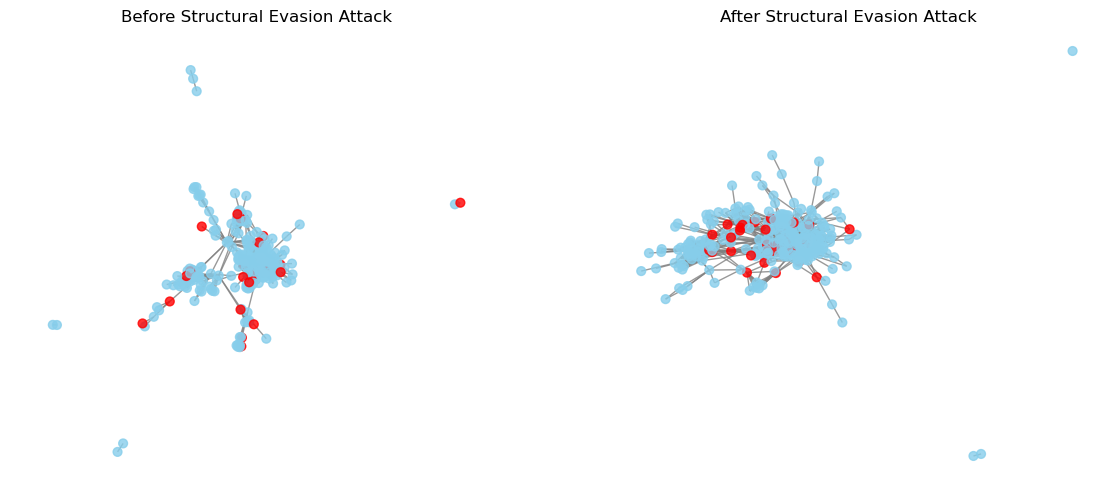

In [19]:
# ------------------------------------------
# Visualization Before & After Evasion Attack
# ------------------------------------------

plt.figure(figsize=(14, 6))


pos = nx.spring_layout(G, seed=42)

# ====================== BEFORE ATTACK ======================
plt.subplot(1, 2, 1)
node_colors = ["red" if n in bot_nodes else "skyblue" for n in G.nodes()]
nx.draw(G, pos, node_size=40, node_color=node_colors, alpha=0.8, edge_color="gray")
plt.title("Before Structural Evasion Attack")

# ====================== AFTER ATTACK =======================
plt.subplot(1, 2, 2)
pos2 = nx.spring_layout(G_evasion, seed=42)
node_colors2 = ["red" if n in bot_nodes else "skyblue" for n in G_evasion.nodes()]
nx.draw(G_evasion, pos2, node_size=40, node_color=node_colors2, alpha=0.8, edge_color="gray")
plt.title("After Structural Evasion Attack")

plt.show()


In [21]:
# ------------------------------------------
# Graph Poisoning Attack
# ------------------------------------------

G_poison = G.copy()

bot_list = list(bot_nodes)
normal_list = list(normal_nodes)

for bot in bot_list:

    # 1) Connect bots together (bot-bot edges)
    bot_partners = np.random.choice(bot_list, size=5, replace=True)
    for b in bot_partners:
        if bot != b:
            G_poison.add_edge(bot, int(b))

    # 2) Add 10 random edges to normal users
    normal_partners = np.random.choice(normal_list, size=10, replace=False)
    for n in normal_partners:
        G_poison.add_edge(bot, int(n))

# 3) Add global noise inside normal graph
extra_noise_edges = 50 

for _ in range(extra_noise_edges):
    u, v = np.random.choice(normal_list, size=2, replace=False)
    G_poison.add_edge(int(u), int(v))

print("Graph Poisoning Attack Completed.")
print(f"Nodes: {G_poison.number_of_nodes()}, Edges: {G_poison.number_of_edges()}")


Graph Poisoning Attack Completed.
Nodes: 333, Edges: 3008


In [23]:
# ------------------------------------------
# Recalculate Metrics After POISONING ATTACK
# ------------------------------------------

degree_poison = dict(G_poison.degree())
clustering_poison = nx.clustering(G_poison)
betweenness_poison = nx.betweenness_centrality(G_poison)

# Communities after poisoning
communities_poison = list(greedy_modularity_communities(G_poison))

community_map_poison = {}
for i, comm in enumerate(communities_poison):
    for node in comm:
        community_map_poison[node] = i

# Create feature dataframe
features_poison = pd.DataFrame({
    "node": list(G_poison.nodes()),
    "degree": [degree_poison[n] for n in G_poison.nodes()],
    "clustering": [clustering_poison[n] for n in G_poison.nodes()],
    "betweenness": [betweenness_poison[n] for n in G_poison.nodes()],
    "community": [community_map_poison[n] for n in G_poison.nodes()],
})

# Keep the same labels (bots stay bots)
features_poison["label"] = features.set_index("node").loc[features_poison["node"]]["label"].values

features_poison.head()


,node,degree,clustering,betweenness,community,label
0,236,38,0.337127,0.011068,1,0
1,186,43,0.473976,0.002951,1,0
2,122,65,0.345673,0.016624,1,0
3,285,47,0.397780,0.010167,1,0
4,24,17,0.683824,0.001387,2,0


In [25]:
# ------------------------------------------
# Train model on POISONED graph
# ------------------------------------------

X_poison = features_poison[["degree", "clustering", "betweenness", "community"]]
y_poison = features_poison["label"]

X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(
    X_poison, y_poison, test_size=0.3, random_state=42
)

clf_poison = RandomForestClassifier(n_estimators=100, random_state=42)
clf_poison.fit(X_train_p, y_train_p)

y_pred_p = clf_poison.predict(X_test_p)

print("=== Bot Detection AFTER POISONING ATTACK ===")
print("Accuracy:", accuracy_score(y_test_p, y_pred_p))
print("\nClassification Report:\n", classification_report(y_test_p, y_pred_p))


=== Bot Detection AFTER POISONING ATTACK ===
Accuracy: 0.67

Classification Report:
               precision    recall  f1-score   support

           0       0.67      1.00      0.80        67
           1       0.00      0.00      0.00        33

    accuracy                           0.67       100
   macro avg       0.34      0.50      0.40       100
weighted avg       0.45      0.67      0.54       100



C:\Users\Sara Ayman\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Sara Ayman\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Sara Ayman\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


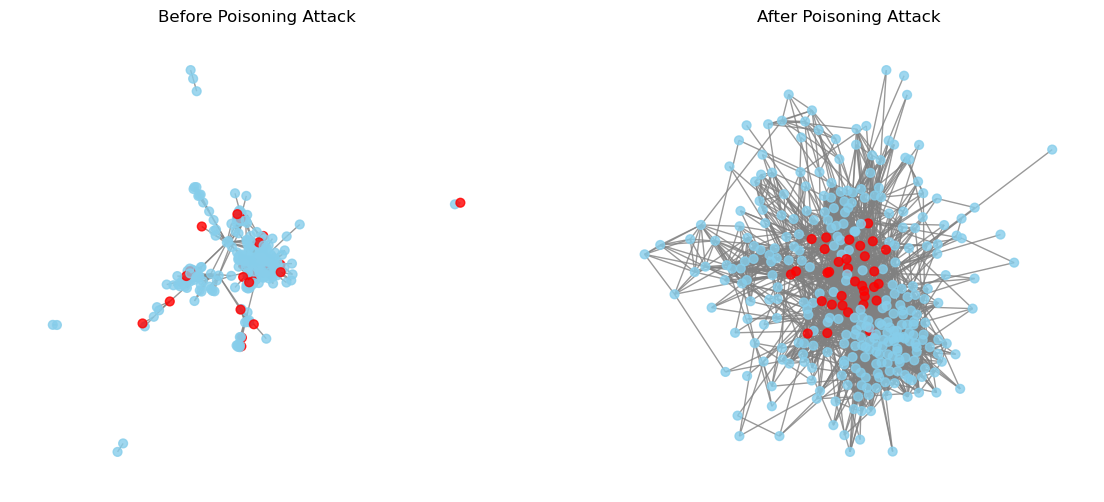

In [27]:
# ------------------------------------------
# Visualization Before & After Graph Poisoning Attack
# ------------------------------------------

plt.figure(figsize=(14, 6))

pos_orig = nx.spring_layout(G, seed=42)

# ============= BEFORE POISONING (Original Graph) =============
plt.subplot(1, 2, 1)
node_colors_orig = ["red" if n in bot_nodes else "skyblue" for n in G.nodes()]
nx.draw(
    G,
    pos_orig,
    node_size=40,
    node_color=node_colors_orig,
    alpha=0.8,
    edge_color="gray"
)
plt.title("Before Poisoning Attack")

# ============= AFTER POISONING ATTACK =============
plt.subplot(1, 2, 2)
pos_poison = nx.spring_layout(G_poison, seed=42)
node_colors_poison = ["red" if n in bot_nodes else "skyblue" for n in G_poison.nodes()]
nx.draw(
    G_poison,
    pos_poison,
    node_size=40,
    node_color=node_colors_poison,
    alpha=0.8,
    edge_color="gray"
)
plt.title("After Poisoning Attack")

plt.show()
